# Character Classification using ResNet9

### The Model is trained over EMNIST dataset

For my course project of course `Deep Learning with PyTorch: Zero to GANs`. I decided to create a neural network model which can classify Numbers, Uppercase English Alphabet characters and Lowercase English Alphabet characters.

For model I have chosen the ResNet9 which I learned in lecture 5 and it is the best model we have learned so far in the course. For model Training I am using EMNIST (Extended MNIST) dataset which have total of 814,255 images 697,932 for training and  116,323 for testing the model. Im using ByClass classification means it has 62 classes [0 - 1] digits, [A - Z] UpperCase Character and [a - z] LowerCase Character. Read more about the dataset in this [PDF](https://arxiv.org/pdf/1702.05373v1.pdf)
 

In [2]:
#Importing the module required for the project

import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import EMNIST
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import pickle 
import requests
import zipfile
import os, shutil
from PIL import Image
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
# The project name
project_name='emnist-project'

Now Dowloading the EMNIST dataset using torch.datasets.EMNIST function. First we have defined the root path, split argument to byclass because we need all the 62 classes. then download to true so that the dataset will be downloaded if it not available, then train and at the last transform. The the transform we are first rotating the image by -90 degree and then a horizintal flip and at last converting them to Tensor.

We have done such transform because the original dataset is little rotated and weird.

In [4]:
dataset = EMNIST(root="data/", split="byclass", download=True, train=True, 
                transform=tt.Compose([
                    lambda img: tt.functional.rotate(img, -90),
                    lambda img: tt.functional.hflip(img),
                    tt.ToTensor()
                ]))
                
test_dataset = EMNIST(root="data/", split="byclass", download=True, train=False, 
                transform=tt.Compose([
                    lambda img: tt.functional.rotate(img, -90),
                    lambda img: tt.functional.hflip(img),
                    tt.ToTensor()
                ]))

Extracting data/EMNIST/raw/emnist.zip to data/EMNIST/raw
Processing byclass


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


In [5]:
print("Total No of Images in EMNIST dataset:", len(dataset) + len(test_dataset))
print("No of images in Training dataset:    ",len(dataset))
print("No of images in Testing dataset:     ",len(test_dataset))

Total No of Images in EMNIST dataset: 814255
No of images in Training dataset:     697932
No of images in Testing dataset:      116323


In [6]:
l = dataset.classes
l.sort()
print("No of classes: ",len(l))
print("List of all classes")
print(l)

No of classes:  62
List of all classes
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [7]:
# This helper funcation convert the output index [0-61] into character [0-9],[A-Z],[a-z]

def to_char(num):
    if num<10:
        return str(num)
    elif num < 36:
        return chr(num+55)
    else:
        return chr(num+61)


# This is reverse of above function. Convert character [0-9],[A-Z],[a-z] into index [0-61]
def to_index(char):
    if ord(char)<59:
        return ord(char)-48
    elif ord(char)<95:
        return ord(char)-55
    else:
        return ord(char)-61


Lets see of the images from the dataset

In [8]:
# Using this function you can see the image and its label form the dataset

def show_example(data):
    img, label = data
    print("Label: ("+to_char(label)+")")
    plt.imshow(img[0], cmap="gray")

Label: (Z)


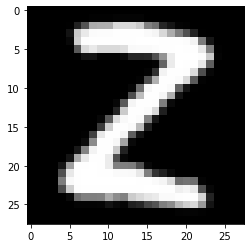

In [9]:
show_example(dataset[0])

Label: (D)


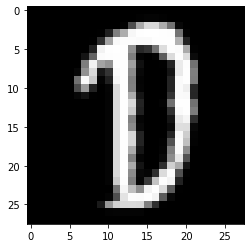

In [10]:
show_example(dataset[1230])

Label: (8)


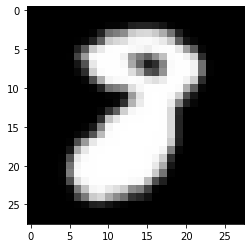

In [11]:
show_example(dataset[20000])

In [12]:
# jovian.commit(project=project_name)

# DataLoader Preparation

Now we are creating Training DataLoader for training the model and Validation DataLoader for validating the model from the dataset

In [13]:
# Set the random seed to get same random split
random_seed = 50
torch.manual_seed(random_seed);

val_size = 50000
train_size = len(dataset) - val_size

# Dividing the dataset into training dataset and validation dataset
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(647932, 50000)

In [14]:
# Creating the training dataloader and validation dataloader wirh 400 batch size

batch_size = 400

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

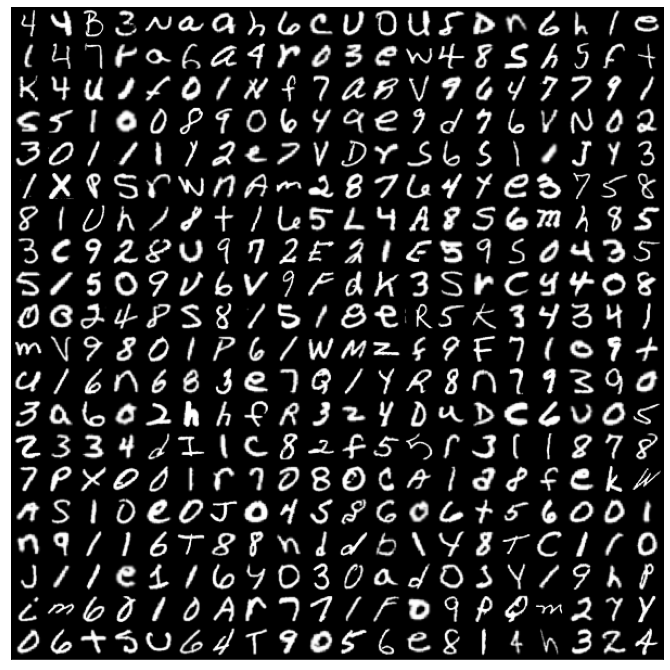

In [15]:
# Lets see a batch of images

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=20).permute(1, 2, 0))
        break
        
show_batch(train_dl)

## LoadData into prefered Runtime Type

Here in the below cell of code we have defined few helper fuction and class which help us to get the information about runtime type i.e. CPU or CUDA. And we can also transfer data from CPU to CUDA if GPU is available

In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
# Returns current working runtype

device = get_default_device()
device

device(type='cuda')

In [18]:
# Lets transfer the training dataloader and validation dataloader to CUDA if available 

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [19]:
# jovian.commit(project=project_name)

# Preparation of the Model

Here we have defined accuray function which return the accuracy of the model for a batch in percentage and evaluate function returns the final loss and accuracy of model over the validation or test dataset

In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

Now defining base class for the model by inheriting nn.Module class and here we have defined the `training_step` function which returns loss of batch, `validation_step` which returns loss and accuracy of a batch of validation dataloader, then `validation_epoch_end` function which return combined loss and accuracy of validation dataloader for an epoch and in end we have `epoch_end` which prints out the final loss and accuray of model after an epoch.

In [21]:
class CharacterClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

Now here we have the ResNet9 model inhering the CharacterClassificationBase class. Here we are performing list of Convolutional Neural Networks ReLUs, MaxPools and Residual blocks. Learn more about ResNet archetecture in this [lecture video](https://www.youtube.com/watch?v=JN7-ZBFYSCU) or this [article](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035)

In [22]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(CharacterClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(7), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [23]:
# Creating the model which take 1 channel input and return 62 channel output and loading into working runtime type

model = to_device(ResNet9(1, 62), device)

# Listing all the layers of the model
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

Here we are defining the `fit_one_cycle` function which is a upgraded version of our basic `fit` function. It comes with new features like `Learning rate scheduling`, `Weight decay`, `Gradient clipping`. Learn more about them in this [notebook](https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/lesson/lesson-5-data-augmentation-regularization-and-resnets).

In [24]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [25]:
# The the evaluation of the untrained model over validation dataset

result = [evaluate(model, val_dl)]
result

[{'val_acc': 0.0362103171646595, 'val_loss': 4.129451751708984}]

### Downloading some essential file for the model from Google Drive

In [26]:
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [27]:
file_id = '1PaJQxzROPvrMC-ku3hYl1Et8m_KiN2q0'
destination = 'emnist_data.zip'
download_file_from_google_drive(file_id, destination)

In [28]:
with zipfile.ZipFile("emnist_data.zip","r") as zip_ref:
    zip_ref.extractall(".")

os.remove('emnist_data.zip')

### Recommended to set train_model to False because it can take over and hour for just 8 epoch to train even on GPU

Now play attention to the below cell. Here you have to set `True` or `False` for the `train_model` variable. If you set it to true the model will train from the beginning and of you set it to False the it is going to use the already trained parameters. By Default its False


In [29]:
train_model = False

Set the Hyper-Parameters for training 

In [30]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [31]:
%%time
if train_model:
    print("Training the model from the begning. Expected time for completion for 8 epochs is 1 hour\n\n")
    history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                                grad_clip=grad_clip, 
                                weight_decay=weight_decay, 
                                opt_func=opt_func)
else:
    print("Using trained pratameters\n")
    print(model.load_state_dict(torch.load('emnist-resnet9.pth', map_location=get_default_device())))
    print()

Using trained pratameters

<All keys matched successfully>

CPU times: user 18.8 ms, sys: 11.5 ms, total: 30.4 ms
Wall time: 35.6 ms


In [32]:
train_time = "53:12"

In [33]:
# jovian.commit(project=project_name)

## Graph of No. Of Epoch vs Accuracy, Loss



In [34]:
# Here if you have trained the model from begning then plot the fresh loss and accuray 
# If not then plot the loss and accuracy of last trining 

if train_model:
    history_file = open('history_file.pickle', 'wb') 
    pickle.dump(history, history_file) 
    history_file.close()
else:
    history_file = open('history_file.pickle', 'rb') 
    history = pickle.load(history_file)
    history_file.close()

In [35]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

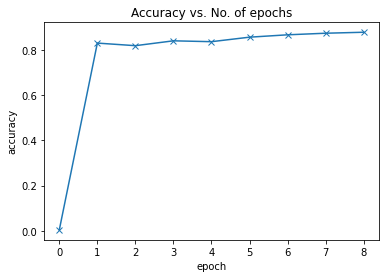

In [36]:
plot_accuracies(history)

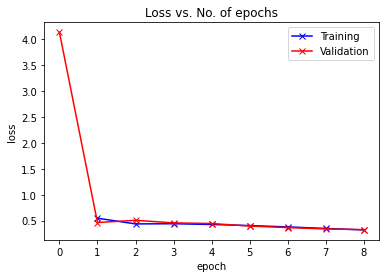

In [37]:
plot_losses(history)

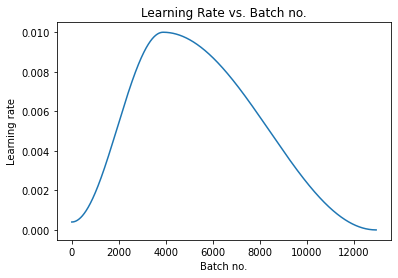

In [38]:
plot_lrs(history)

In [40]:
# jovian.commit(project=project_name)

### Lets see the final result and Check some predectition 

In [43]:
# The the evaluation of the model over validation dataset
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=400), device)
result = [evaluate(model, val_dl)]
print("The final Accuracy of model on Test Dataset:", result[0]["val_acc"])
print("The final Loss of model on Test Dataset:    ", result[0]["val_loss"])

The final Accuracy of model on Test Dataset: 0.8769245743751526
The final Loss of model on Test Dataset:     0.3251490294933319


In [44]:
def predict_image(data):
    print("Predected Character: "+ to_char(torch.max(model(to_device(data[0].unsqueeze(0), device)), dim=1)[1].item()))
    print("Labeled:" , to_char(data[1]))
    plt.imshow(data[0][0], cmap="gray");

Predected Character: w
Labeled: W


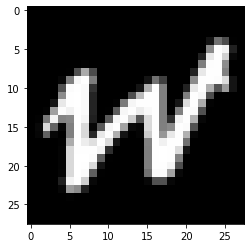

In [45]:
predict_image(dataset[1340])

Predected Character: e
Labeled: e


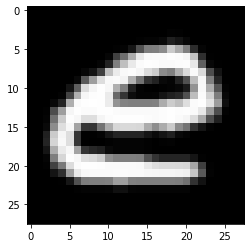

In [46]:
predict_image(dataset[65754])

Predected Character: 3
Labeled: 3


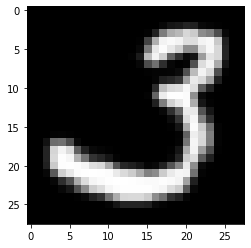

In [47]:
predict_image(dataset[3])

## Predection over Self Made Image data

The predection over self made images. These images is not a part of `EMNIST` dataset. I created them using GIMP

In [48]:
with zipfile.ZipFile("self_test.zip","r") as zip_ref:
    zip_ref.extractall(".")

Predected Character: Z
Labeled: z


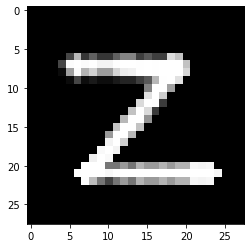

In [49]:
label = "z"

image = Image.open('self_test/1.png')
image=tt.ToTensor()(image)
predict_image((image, to_index(label)))

Predected Character: Y
Labeled: Y


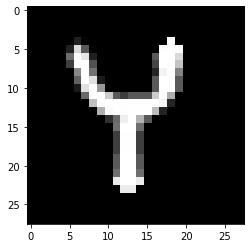

In [50]:
label = "Y"

image = Image.open('self_test/2.png')
image=tt.ToTensor()(image)
predict_image((image, to_index(label)))

Predected Character: 5
Labeled: 5


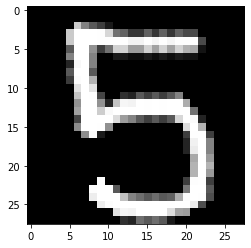

In [51]:
label = "5"

image = Image.open('self_test/3.png')
image=tt.ToTensor()(image)
predict_image((image, to_index(label)))

Predected Character: S
Labeled: S


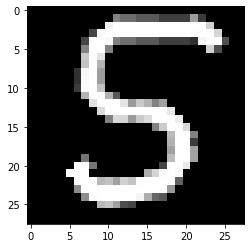

In [52]:
label = "S"

image = Image.open('self_test/4.png')
image=tt.ToTensor()(image)
predict_image((image, to_index(label)))

Predected Character: 4
Labeled: 4


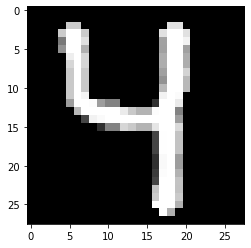

In [53]:
label = "4"

image = Image.open('self_test/5.png')
image=tt.ToTensor()(image)
predict_image((image, to_index(label)))

Predected Character: O
Labeled: o


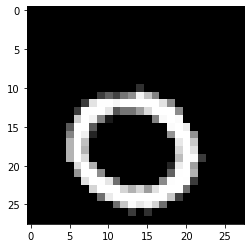

In [54]:
label = "o"

image = Image.open('self_test/6.png')
image=tt.ToTensor()(image)
predict_image((image, to_index(label)))

Predected Character: d
Labeled: d


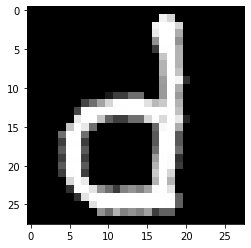

In [55]:
label = "d"

image = Image.open('self_test/7.png')
image=tt.ToTensor()(image)
predict_image((image, to_index(label)))

Predected Character: e
Labeled: e


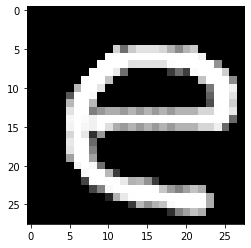

In [56]:
label = "e"

image = Image.open('self_test/8.png')
image=tt.ToTensor()(image)
predict_image((image, to_index(label)))

Predected Character: G
Labeled: G


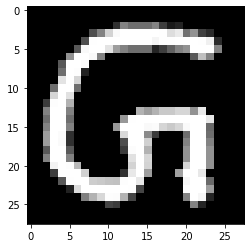

In [57]:
label = "G"

image = Image.open('self_test/9.png')
image=tt.ToTensor()(image)
predict_image((image, to_index(label)))

Predected Character: L
Labeled: L


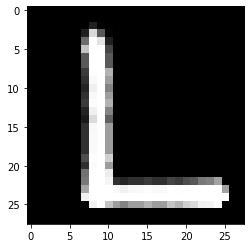

In [58]:
label = "L"

image = Image.open('self_test/10.png')
image=tt.ToTensor()(image)
predict_image((image, to_index(label)))

In [59]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/anurag3301/emnist-project


'https://jovian.ai/anurag3301/emnist-project'

### Saving and logging the model data and information

In [60]:
torch.save(model.state_dict(), 'emnist-resnet9.pth')

In [61]:
jovian.reset()
jovian.log_hyperparams(arch='resnet9', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [62]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

[jovian] Metrics logged.


In [63]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/anurag3301/emnist-project


'https://jovian.ai/anurag3301/emnist-project'